# Final Project Notebook



## Introduction

This notebook addresses the questions outlined in the project. It includes data preprocessing, analysis, visualizations, and recommendations for optimizing fuel inventory management.


## Imports and Setups

In [ ]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set global visual parameters
plt.rcParams['figure.figsize'] = [12, 6]

# Paths to datasets
locations_path = 'Locations-1.csv'
tanks_path = 'Tanks-1.csv'
invoices_path = 'Invoices-1.csv'
fuel_levels_part1_path = 'Fuel_Level_Part_1-1.csv'
fuel_levels_part2_path = 'Fuel_Level_Part_2-1.csv'


In [ ]:
# Load datasets
locations_df = pd.read_csv(locations_path)
tanks_df = pd.read_csv(tanks_path)
invoices_df = pd.read_csv(invoices_path)
fuel_levels_part1_df = pd.read_csv(fuel_levels_part1_path)
fuel_levels_part2_df = pd.read_csv(fuel_levels_part2_path)

# Display initial dataframes
print("Locations Data:")
print(locations_df.head())
print("\nTanks Data:")
print(tanks_df.head())
print("\nInvoices Data:")
print(invoices_df.head())
print("\nFuel Levels Part 1 Data:")
print(fuel_levels_part1_df.head())
print("\nFuel Levels Part 2 Data:")
print(fuel_levels_part2_df.head())

Locations Data:
   Gas Station Location Gas Station Name  \
0                     1        EastMount   
1                     2         Eastgate   
2                     3          Central   
3                     4          Chedoke   
4                     5    Mountain View   

                                 Gas Station Address  Gas Station Latitude  \
0   386 Upper Gage Ave, Hamilton, ON L8V 4H9, Canada             43.234670   
1  75 Centennial Pkwy N E5, Hamilton, ON L8E 2P2,...             43.230700   
2         80 Park St N, Hamilton, ON L8R 2M9, Canada             43.260260   
3        16 McMaster Ave, Dundas, ON L9H 0A8, Canada             43.261849   
4        985 Scenic Dr, Hamilton, ON L9C 1H7, Canada             43.244910   

   Gas Station Longitude  
0             -79.836510  
1             -79.763930  
2             -79.870580  
3             -79.937057  
4             -79.921850  

Tanks Data:
  Tank ID  Tank Location  Tank Number Tank Type  Tank Capacity
0    T 10   

## 1. Evaluate Current Inventory Management Practices
### Data Preprocessing

#### Combine and clean Fuel Level Data

In [ ]:
# Concatenate fuel level datasets
fuel_levels_part1_df.rename(columns={"Fuel Level": "Fuel Level", "Time stamp": "Timestamp", "Tank ID": "Tank ID"}, inplace=True)
fuel_levels_part2_df.rename(columns={"Fuel_Level": "Fuel Level", "Timestamp": "Timestamp", "Tank ID": "Tank ID"}, inplace=True)
fuel_levels_df = pd.concat([fuel_levels_part1_df, fuel_levels_part2_df], ignore_index=True)

# Standardize Tank IDs
fuel_levels_df['Tank ID'] = fuel_levels_df['Tank ID'].str.replace(" ", "")
tanks_df['Tank ID'] = tanks_df['Tank ID'].str.replace(" ", "")

# Identify missing values
missing_fuel_levels = fuel_levels_df['Fuel Level'].isnull().sum()
print(f"Missing Fuel Level Data: {missing_fuel_levels}")


Missing Fuel Level Data: 2


In [ ]:
# Fill missing values using forward-fill method
fuel_levels_df.loc[:, 'Fuel Level'] = fuel_levels_df['Fuel Level'].fillna(method='ffill')

/var/folders/2t/2d4kfxgs0b9_dn_n2vtm3mb00000gn/T/ipykernel_81436/3252069002.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fuel_levels_df.loc[:, 'Fuel Level'] = fuel_levels_df['Fuel Level'].fillna(method='ffill')


#### Merge and clean other Datasets

In [ ]:
merged_df = (invoices_df
             .merge(tanks_df, left_on='Invoice Gas Station Location', right_on='Tank Location')
             .merge(locations_df, left_on='Invoice Gas Station Location', right_on='Gas Station Location'))

# Analyze and handle missing values
missing_summary = merged_df.isnull().sum()
print("Missing Values Summary:")
print(missing_summary)


Missing Values Summary:
Invoice Date                      0
Invoice ID                      110
Invoice Gas Station Location      0
Gross Purchase Cost             116
Amount Purchased                116
Fuel Type                       116
Tank ID                           0
Tank Location                     0
Tank Number                       0
Tank Type                         0
Tank Capacity                     0
Gas Station Location              0
Gas Station Name                  0
Gas Station Address               0
Gas Station Latitude              0
Gas Station Longitude             0
dtype: int64


In [ ]:
# Fill numerical columns with median and categorical columns with mode
merged_df= merged_df.dropna()
merged_df.isnull().sum()

Invoice Date                    0
Invoice ID                      0
Invoice Gas Station Location    0
Gross Purchase Cost             0
Amount Purchased                0
Fuel Type                       0
Tank ID                         0
Tank Location                   0
Tank Number                     0
Tank Type                       0
Tank Capacity                   0
Gas Station Location            0
Gas Station Name                0
Gas Station Address             0
Gas Station Latitude            0
Gas Station Longitude           0
dtype: int64

### Visualizing Fuel Levels

Given the size of the data and the usefulness of these plots, we will only plot every 10th row for each Tank ID. The plots will still show the necessary information but run much faster

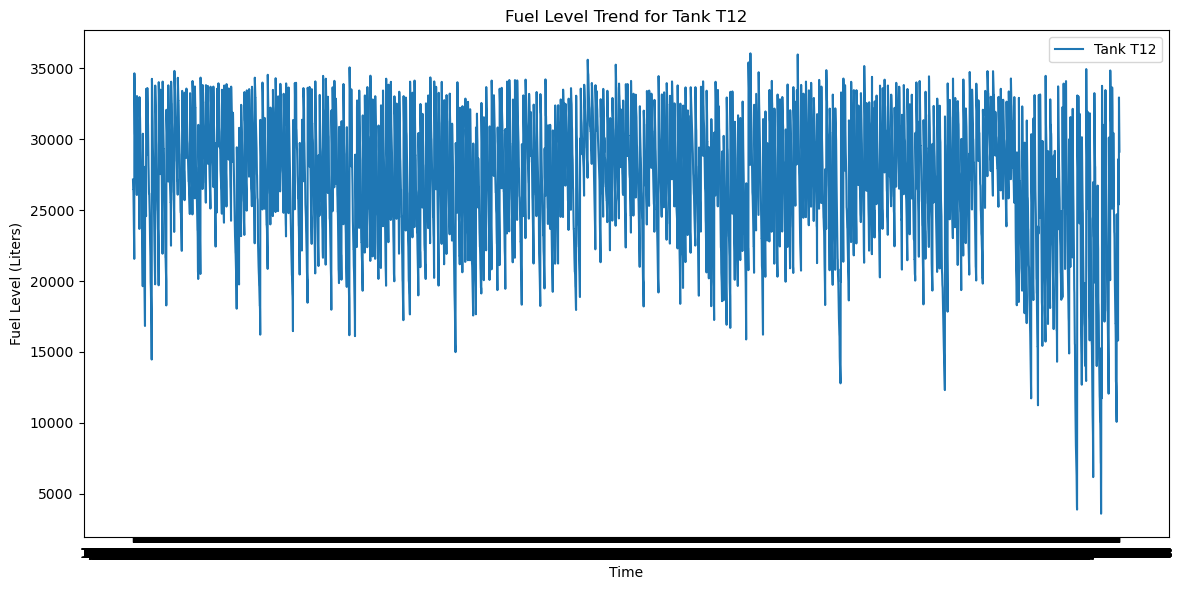

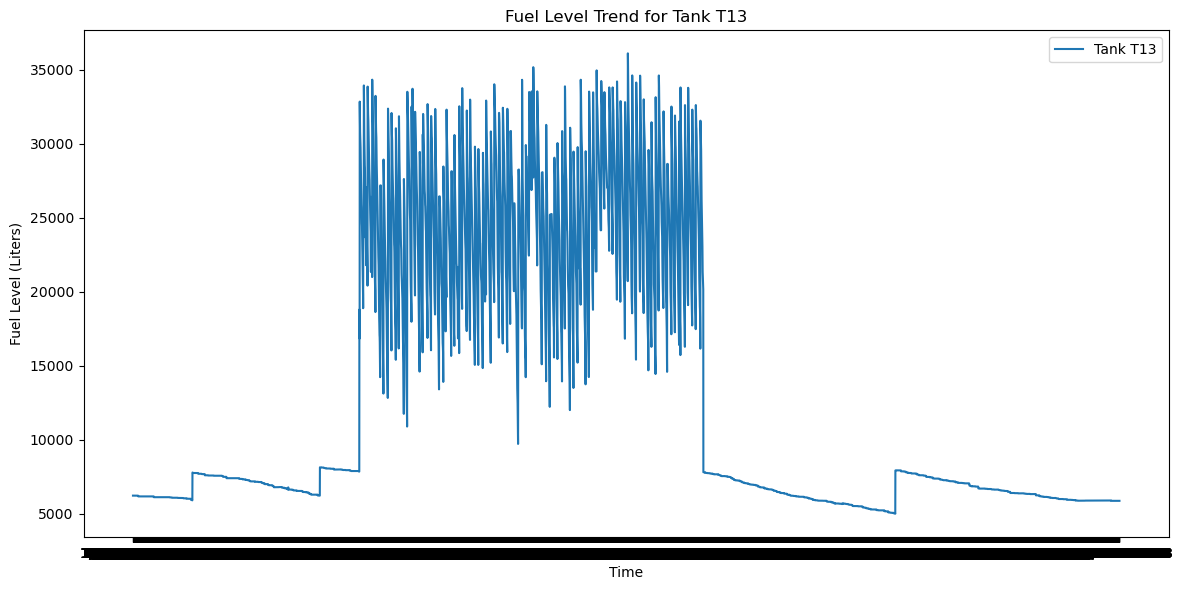

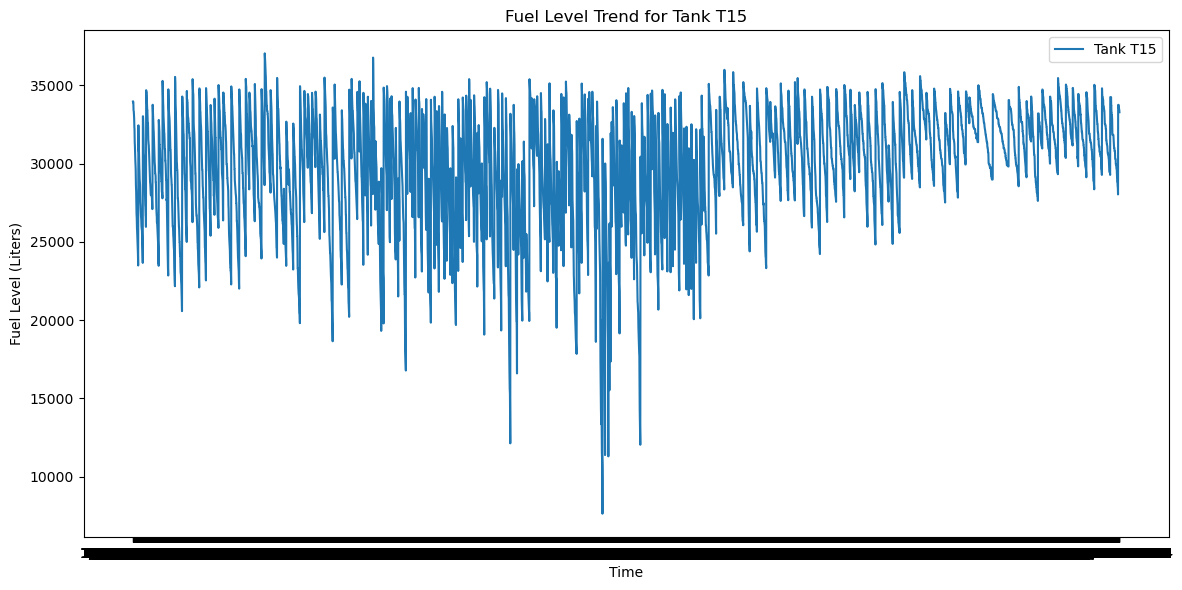

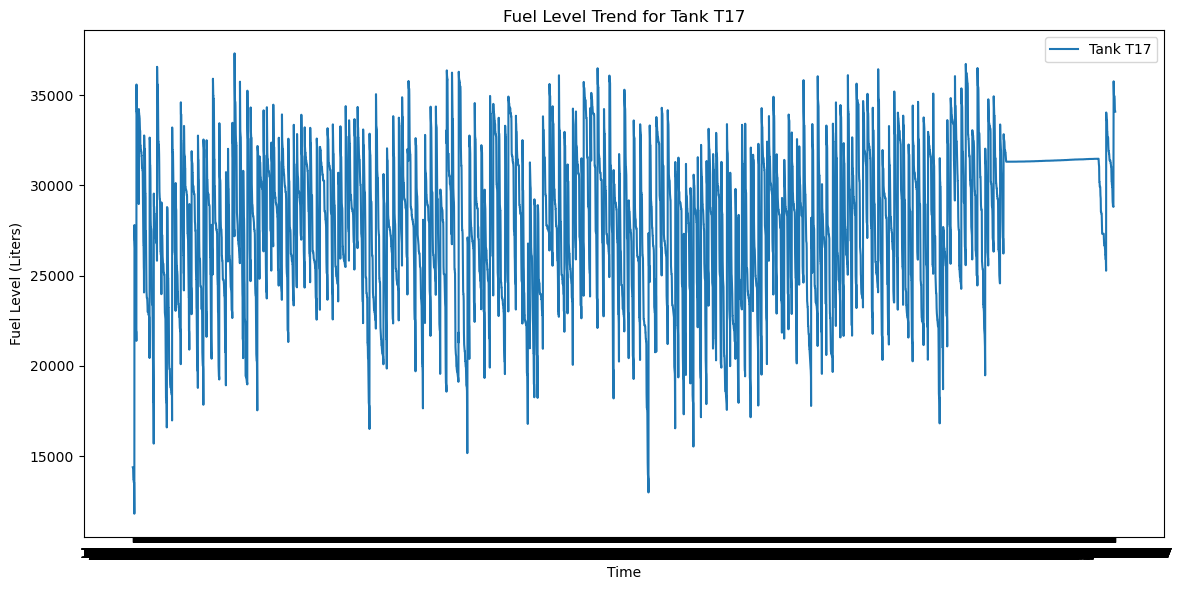

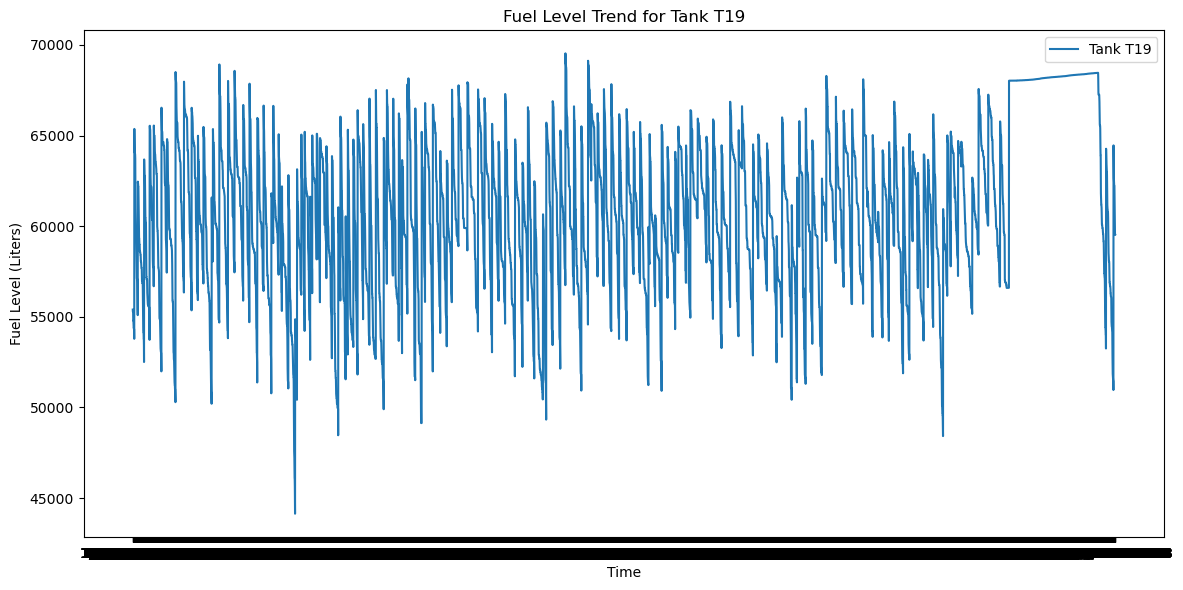

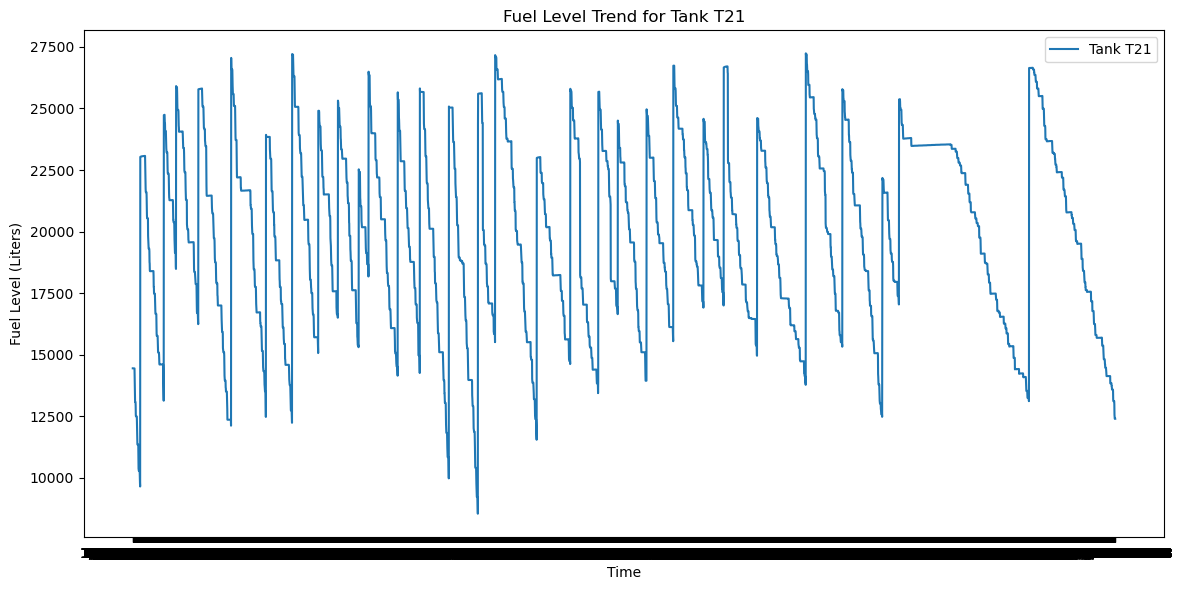

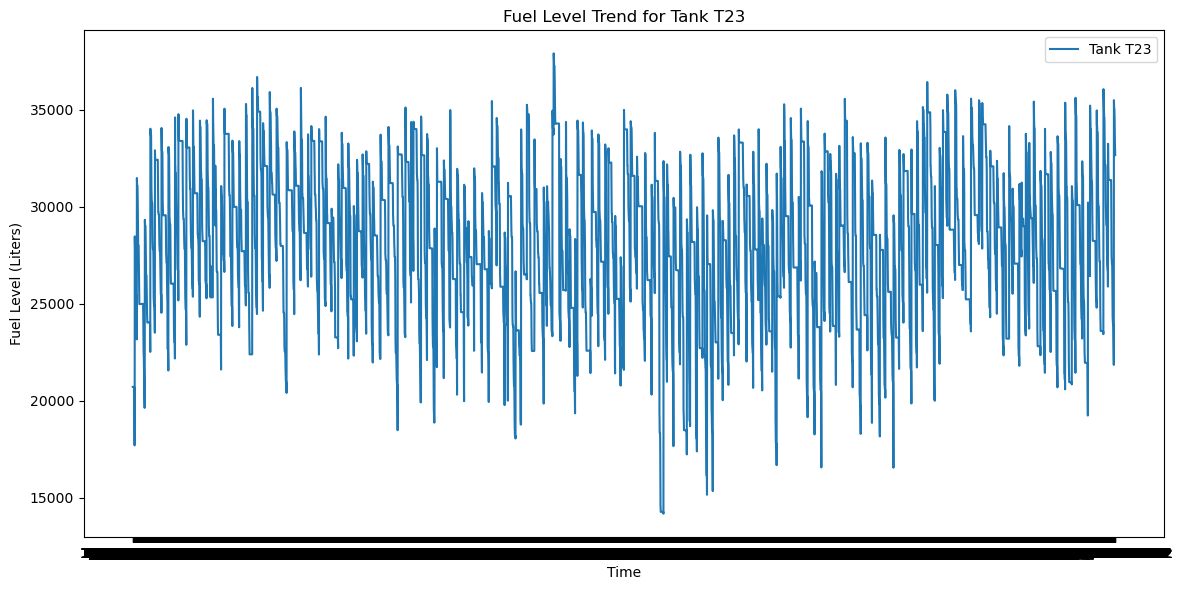

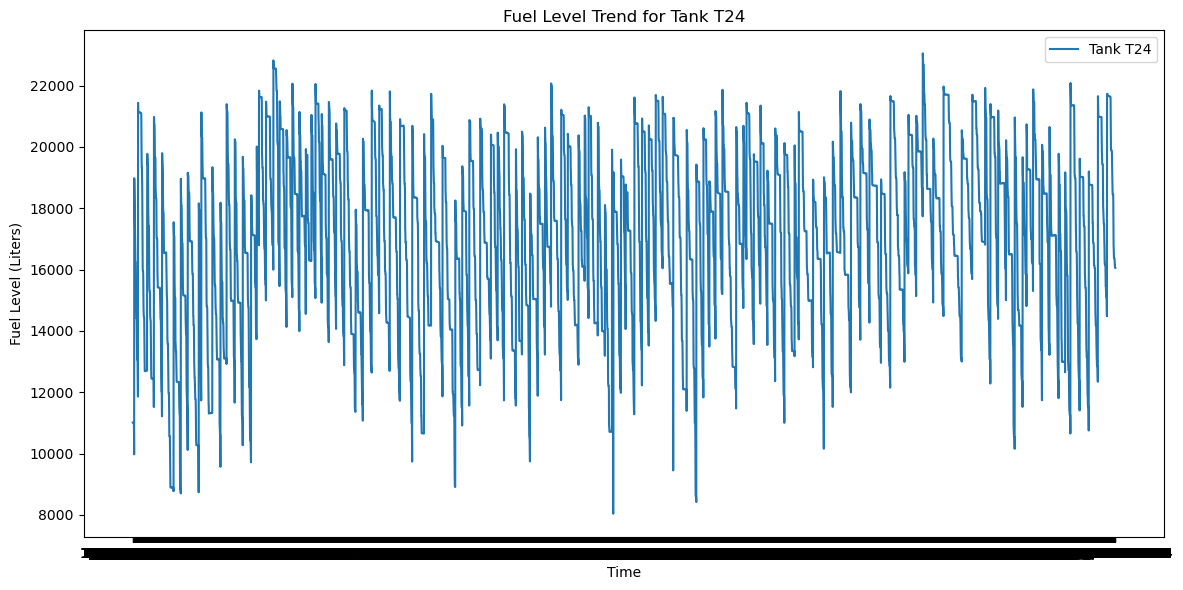

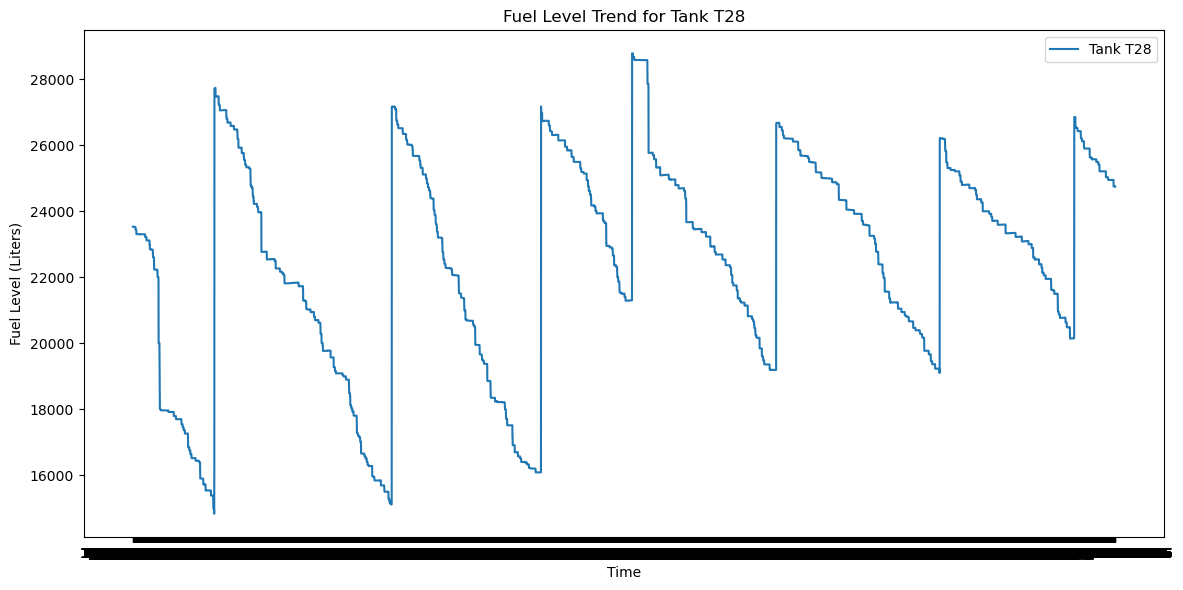

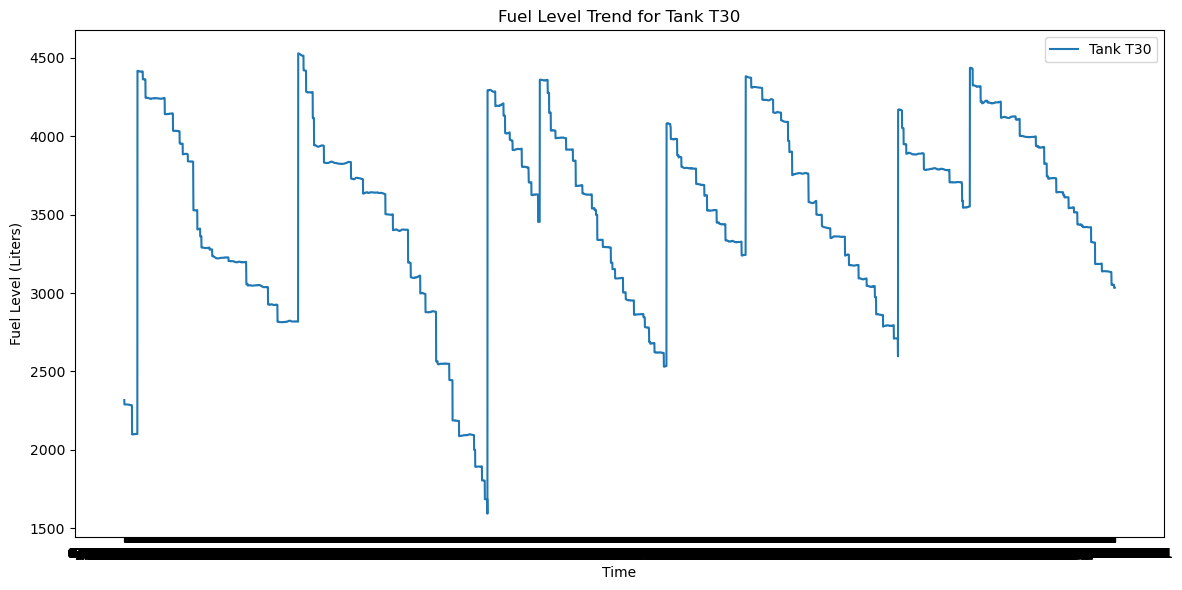

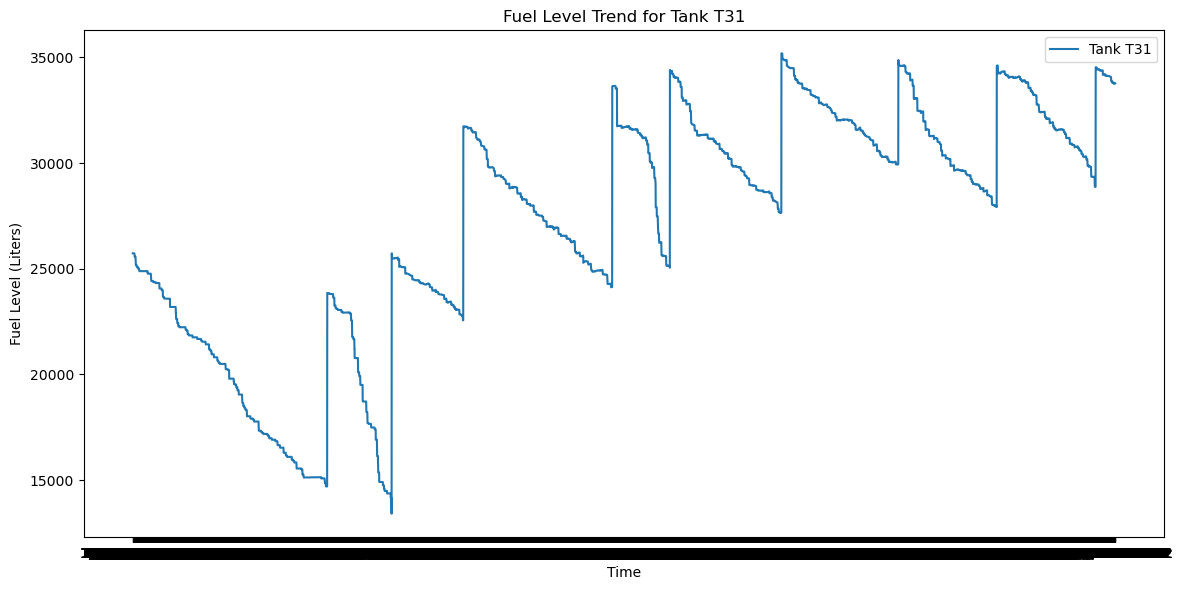

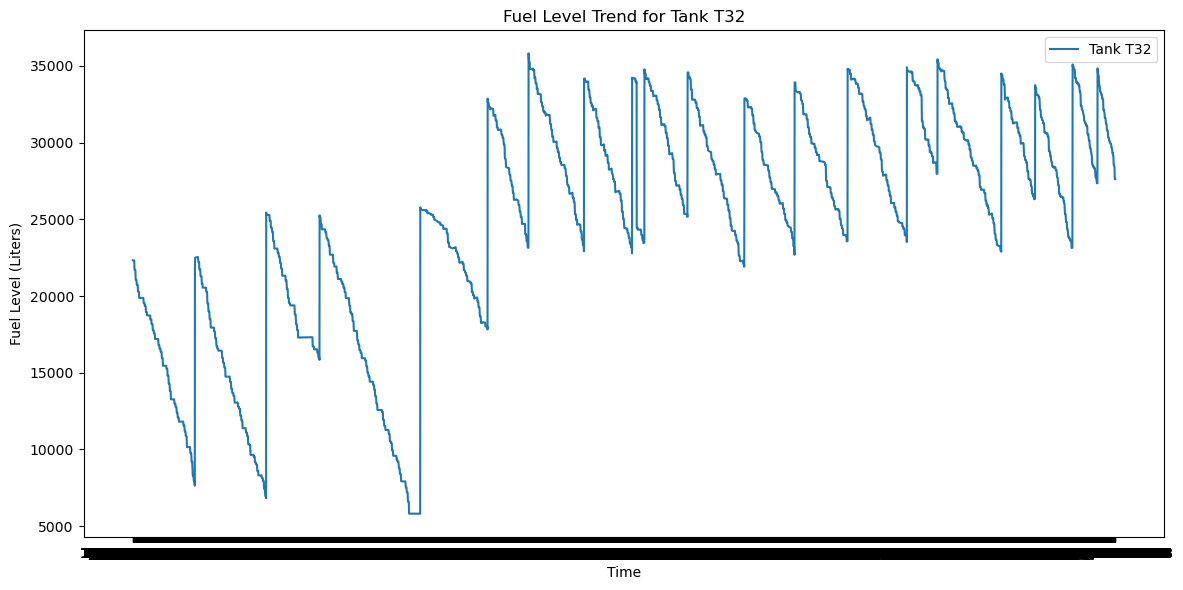

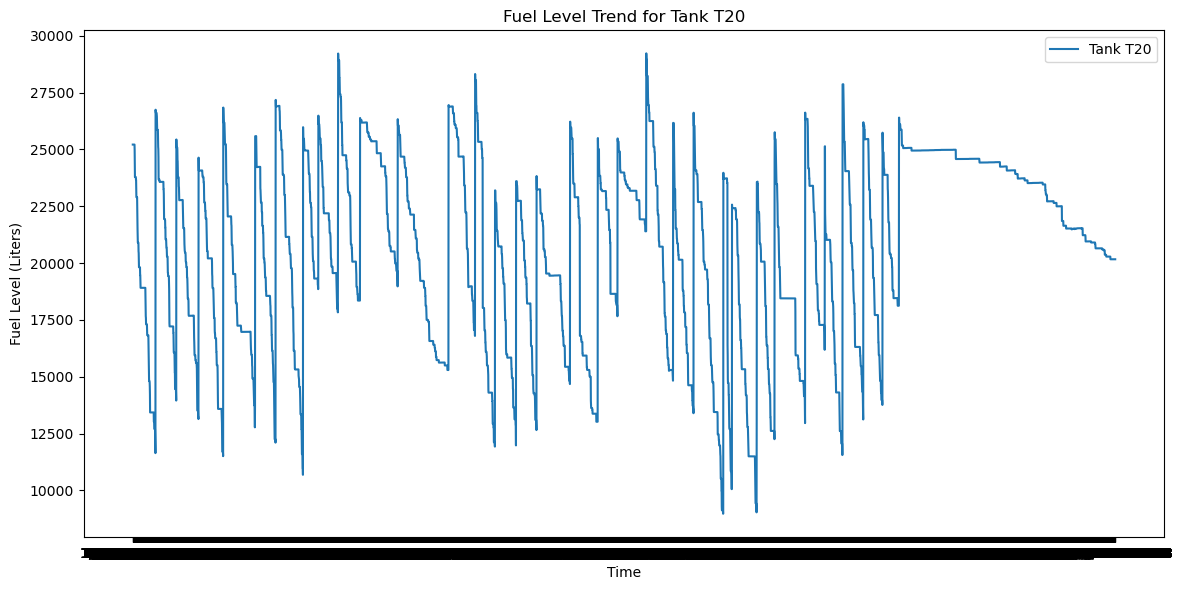

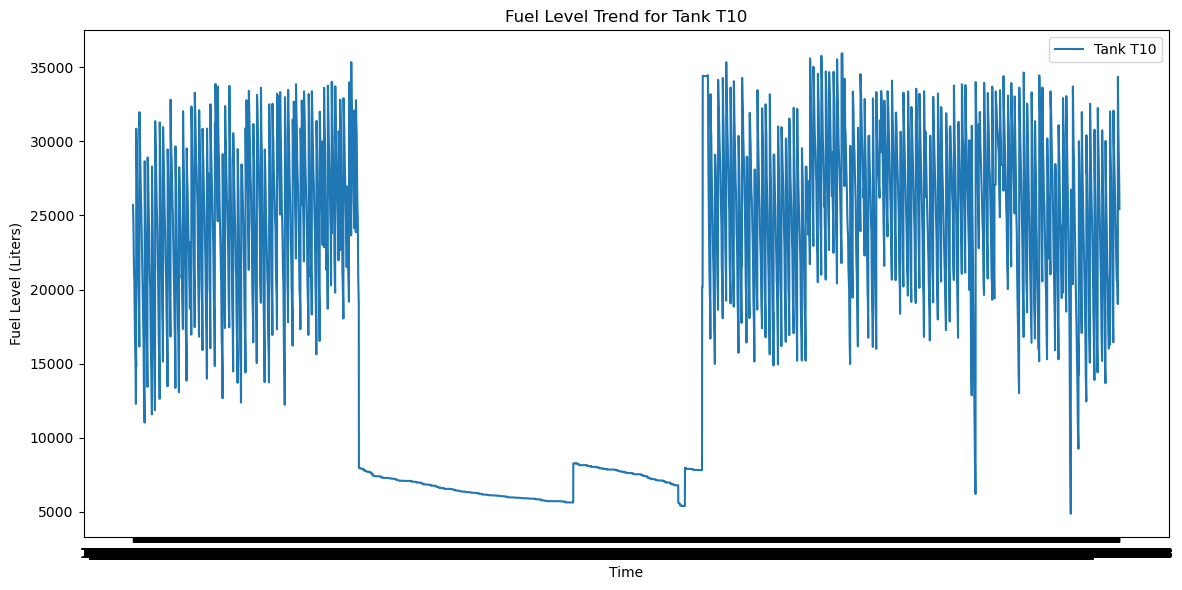

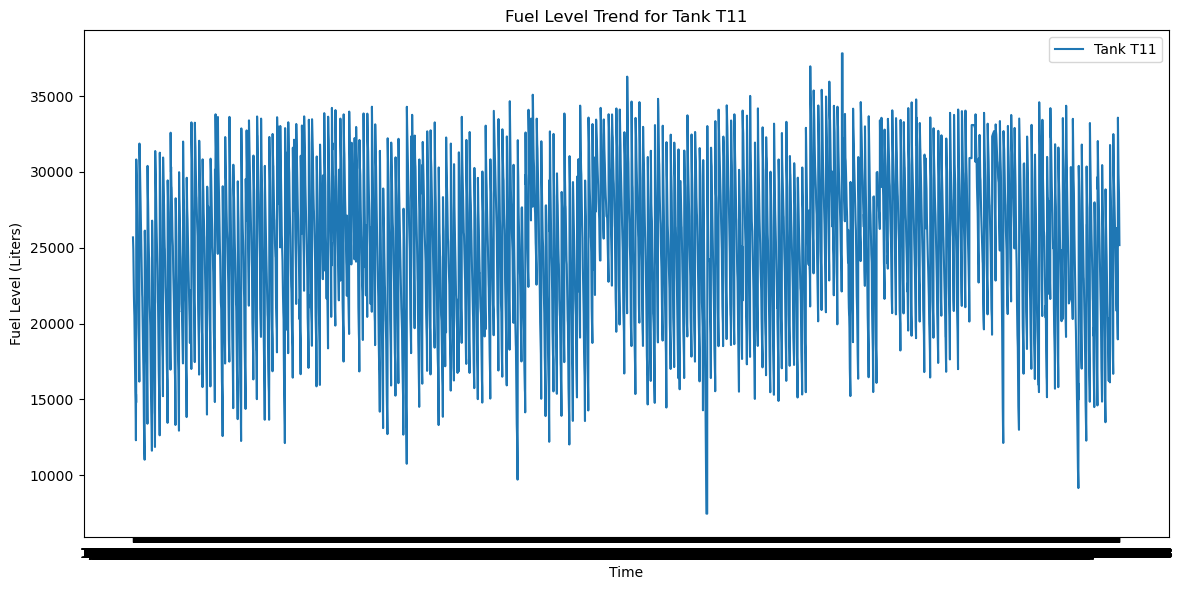

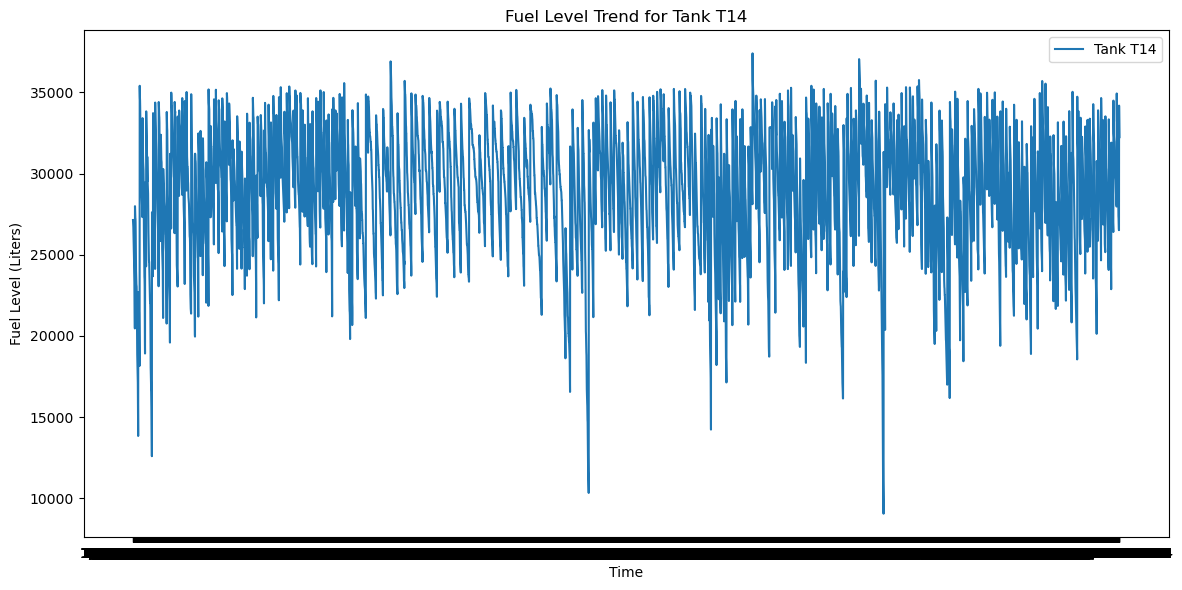

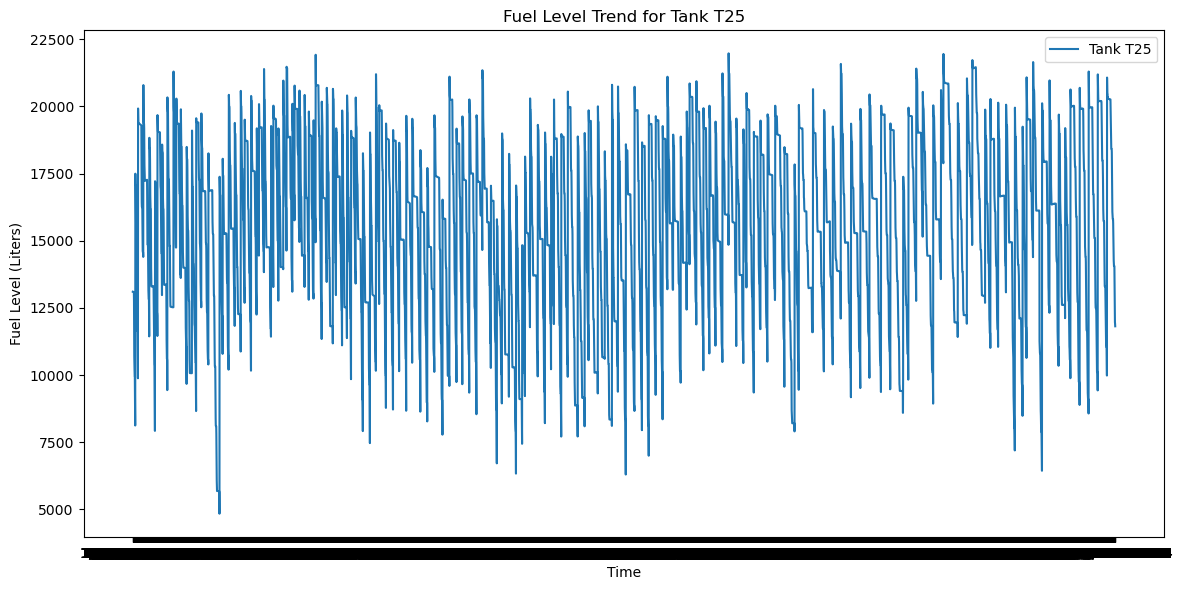

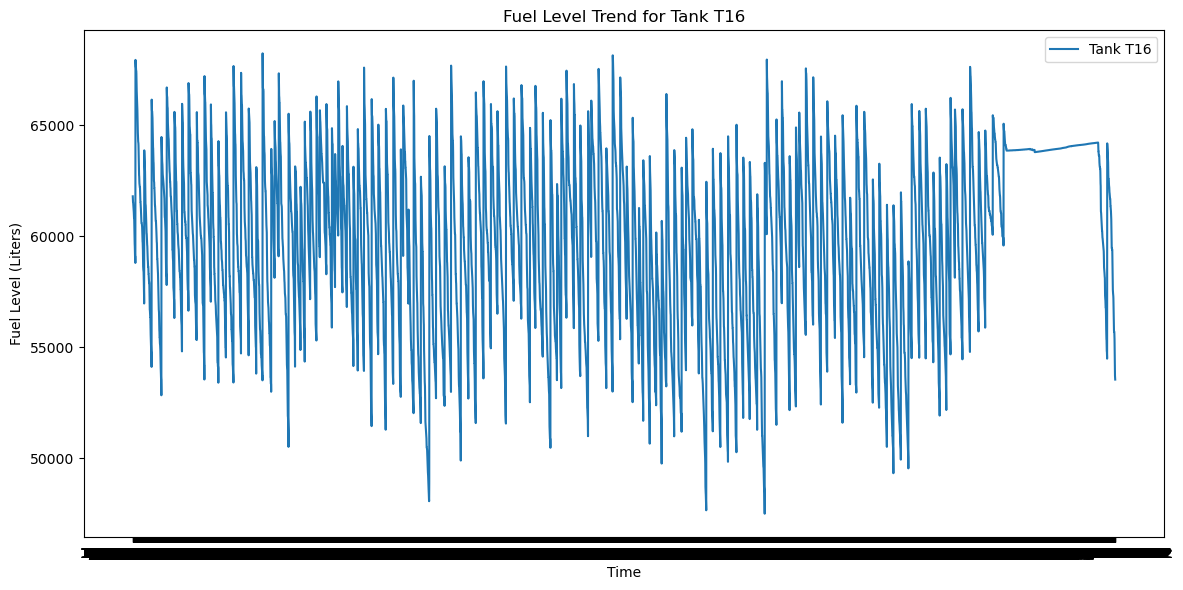

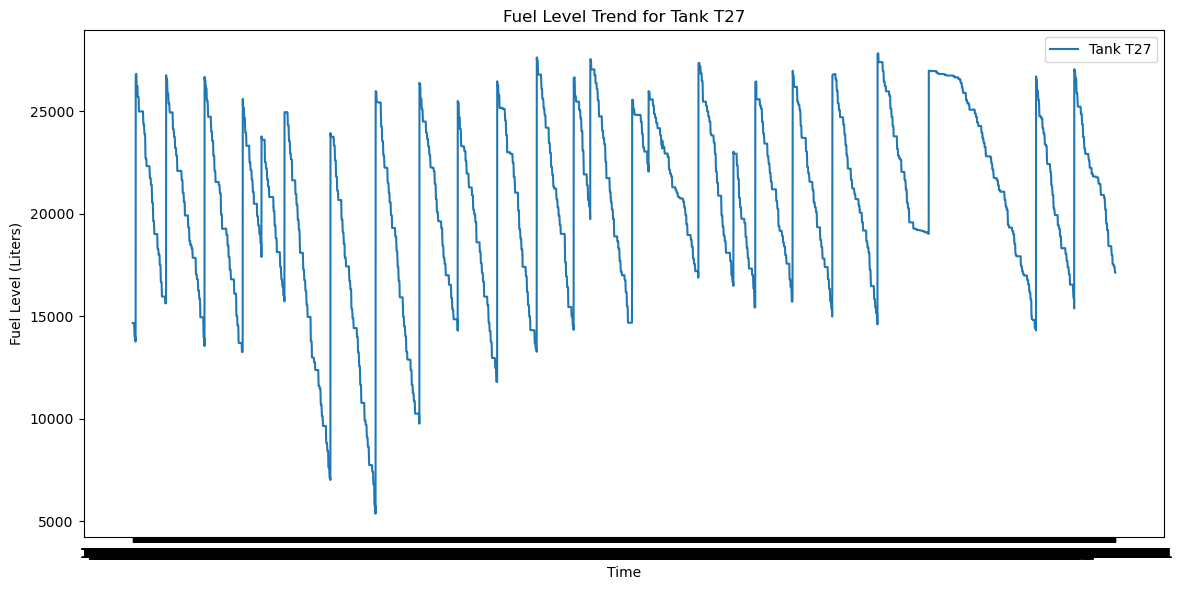

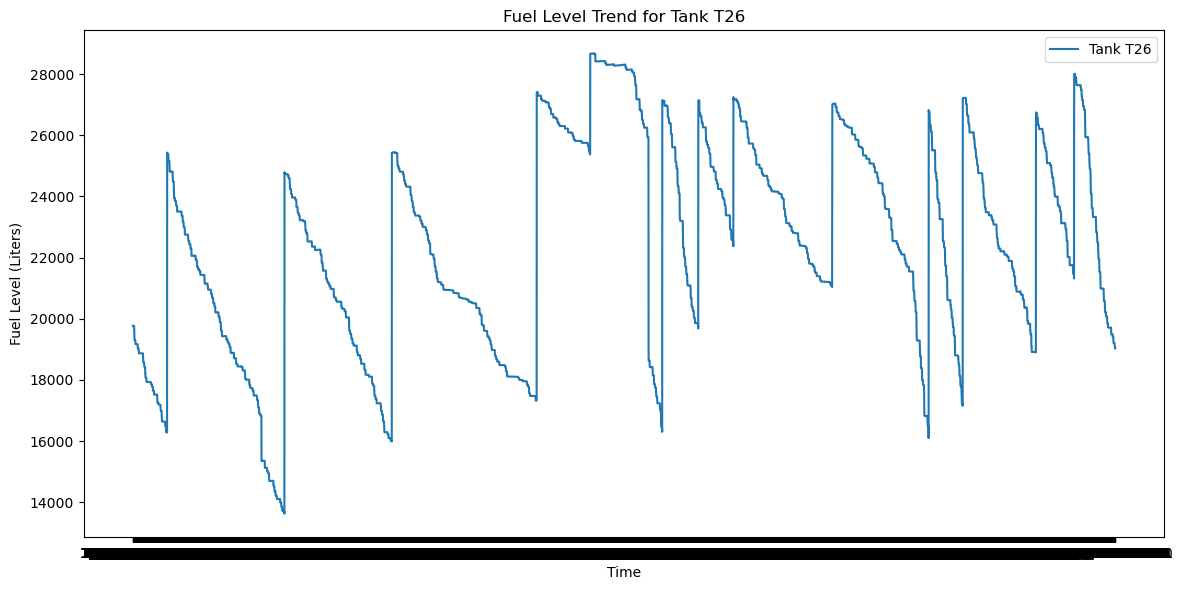

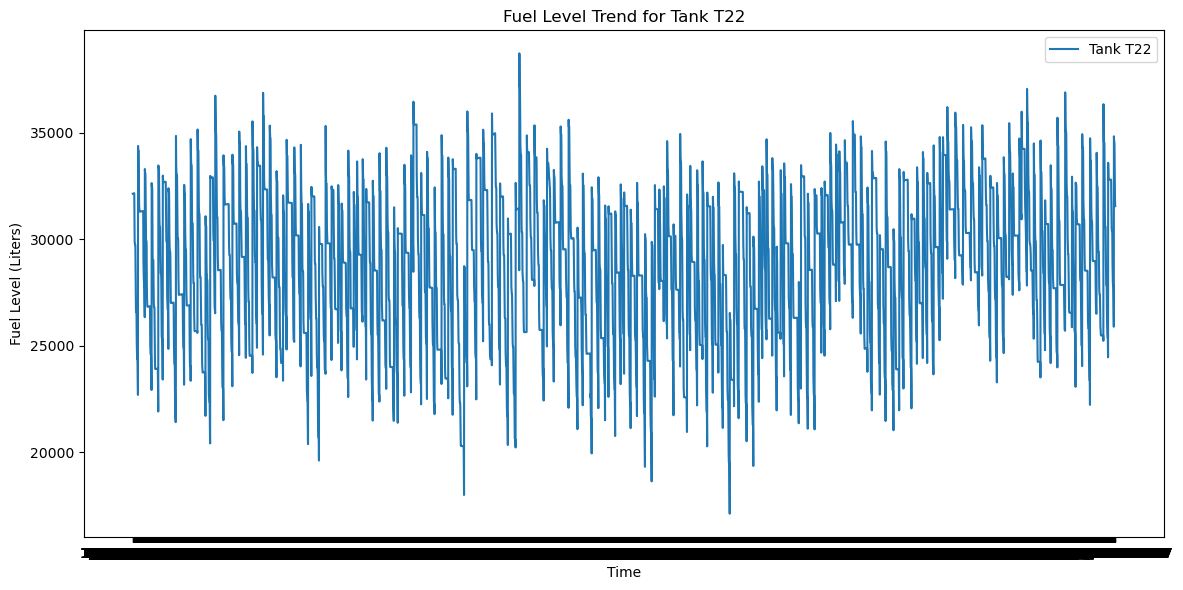

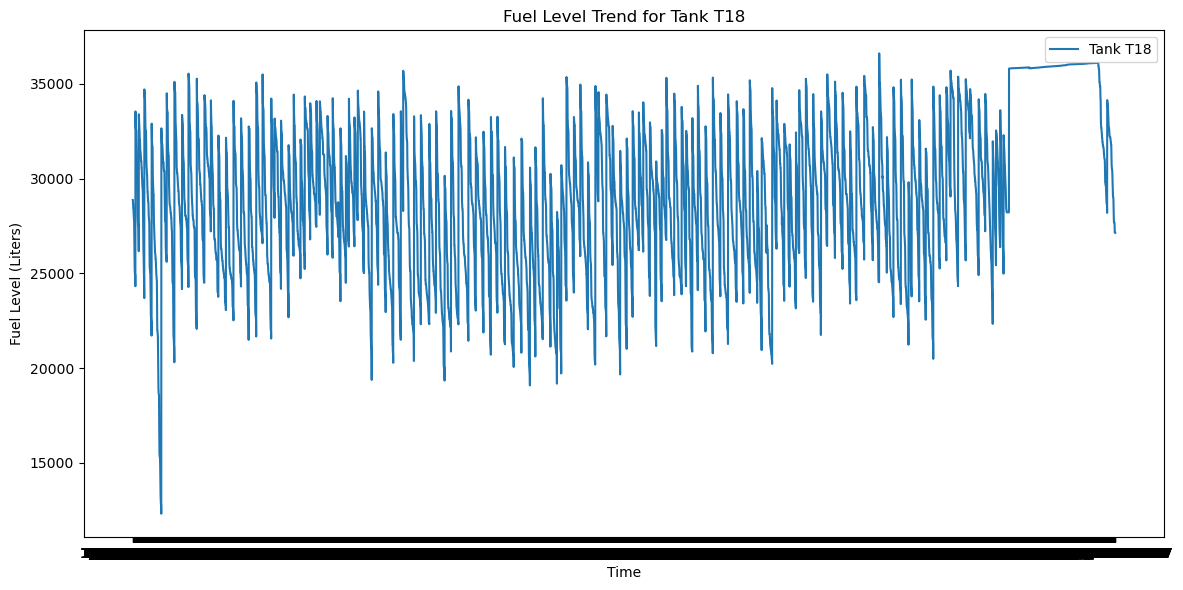

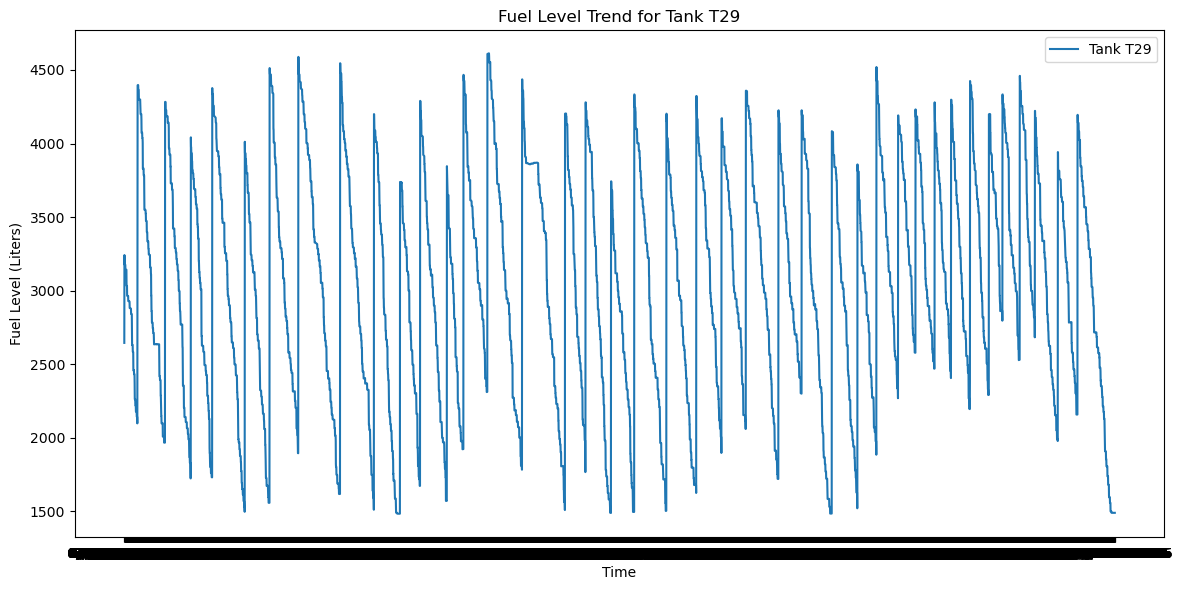

In [ ]:
# Plot inventory trends for each tank one by one
def plot_fuel_levels_one_by_one(fuel_data):
    unique_tanks = fuel_data['Tank ID'].unique()
    for tank_id in unique_tanks:
        subset = fuel_data[fuel_data['Tank ID'] == tank_id]
        subset = subset[::10]
        plt.figure(figsize=(12, 6))
        plt.plot(subset['Timestamp'], subset['Fuel Level'], label=f'Tank {tank_id}')
        plt.title(f"Fuel Level Trend for Tank {tank_id}")
        plt.xlabel("Time")
        plt.ylabel("Fuel Level (Liters)")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Plot each tank individually
plot_fuel_levels_one_by_one(fuel_levels_df)

To assess the effectiveness of inventory managerment, we will look at each location's fuel level and if one's fuel level has crossed a certain threshold multiple time. For the purpose of this report, we will use 20% of the total fuel level as the risk threshold

In [ ]:
def assess_inventory_risks(fuel_data, tanks_data):
    # Merge fuel data with tank locations
    fuel_data = fuel_data.merge(tanks_data[['Tank ID', 'Tank Location', 'Tank Capacity']], on='Tank ID', how='left')

    # Calculate total capacity and total fuel level per station
    station_stats = (fuel_data.groupby(['Tank Location', 'Timestamp'])
                     .agg(
                         TotalCapacity=('Tank Capacity', 'sum'),
                         TotalFuelLevel=('Fuel Level', 'sum')
                     )
                     .reset_index())

    # Define stockout threshold as 20% of total capacity per station
    station_stats['Stockout Threshold'] = station_stats['TotalCapacity'] * 0.2

    # Identify stations at risk of stockouts
    station_stats['At Risk'] = station_stats['TotalFuelLevel'] < station_stats['Stockout Threshold']

    # Aggregate risk summary by station
    risk_summary = (station_stats.groupby('Tank Location')
                    .agg(
                        TotalCapacity=('TotalCapacity', 'mean'),
                        AverageFuelLevel=('TotalFuelLevel', 'mean'),
                        BelowThresholdDays=('At Risk', 'sum'),
                        AtRisk=('At Risk', 'any')
                    )
                    .reset_index())

    # Add an indicator for effective inventory management
    risk_summary['Effective Management'] = ~risk_summary['AtRisk']

    print("\nInventory Risk Assessment Summary by Station:")
    print(risk_summary)
    return risk_summary


In [ ]:
assess_inventory_risks(fuel_levels_df, tanks_df)


Inventory Risk Assessment Summary by Station:
   Tank Location  TotalCapacity  AverageFuelLevel  BelowThresholdDays  AtRisk  \
0              1  127797.980825      75979.540034                4770    True   
1              2  132678.536869     107206.569770                   0   False   
2              3   52241.048348      35312.110645                   0   False   
3              4   74315.651604      52735.330558                   0   False   
4              5   44685.939586      29100.232696                   0   False   
5              6   68112.150521      49496.853760                   0   False   
6              7    8522.541733       5588.320933                   0   False   
7              8   66793.896269      43513.039948                1645    True   

   Effective Management  
0                 False  
1                  True  
2                  True  
3                  True  
4                  True  
5                  True  
6                  True  
7              

,Tank Location,TotalCapacity,AverageFuelLevel,BelowThresholdDays,AtRisk,Effective Management
0,1,127797.980825,75979.540034,4770,True,False
1,2,132678.536869,107206.569770,0,False,True
2,3,52241.048348,35312.110645,0,False,True
3,4,74315.651604,52735.330558,0,False,True
4,5,44685.939586,29100.232696,0,False,True
5,6,68112.150521,49496.853760,0,False,True
6,7,8522.541733,5588.320933,0,False,True
7,8,66793.896269,43513.039948,1645,True,False


On the station level, station 1 and 8 might need more attention from the management, and may at risk of stockouts.

### Quantify Current Performance


The metric we use here is cost saving per station per month and cost saving per station per year. The results are saved into dfs and displayed.

In [ ]:
def calculate_discounts(df):
    df['Discount'] = 0
    conditions = [
        df['Amount Purchased'] > 40000,
        (df['Amount Purchased'] > 25000) & (df['Amount Purchased'] <= 40000),
        (df['Amount Purchased'] > 15000) & (df['Amount Purchased'] <= 25000),
    ]
    values = [0.04, 0.03, 0.02]
    df['Discount'] = np.select(conditions, values, default=0) * df['Amount Purchased']

    # Calculate total savings per station
    df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])
    df['Month'] = df['Invoice Date'].dt.to_period('M')

    monthly_savings = (df.groupby(['Invoice Gas Station Location', 'Month'])[['Discount']]
                         .sum()
                         .reset_index()
                         .rename(columns={'Discount': 'Monthly Savings'}))

    yearly_savings = (df.groupby('Invoice Gas Station Location')[['Discount']]
                        .sum()
                        .reset_index()
                        .rename(columns={'Discount': 'Yearly Savings'}))

    print("Monthly Savings per Station:")
    print(monthly_savings)
    print("\nYearly Savings per Station:")
    print(yearly_savings)

    # Print out tank-wise results
    print("\nTank-wise Savings Details:")
    for station_id, station_data in df.groupby('Invoice Gas Station Location'):
        print(f"Station {station_id} - Total Savings: {station_data['Discount'].sum():.2f}")

    return df, monthly_savings, yearly_savings

invoices_df, monthly_savings, yearly_savings = calculate_discounts(merged_df)


Monthly Savings per Station:
     Invoice Gas Station Location    Month  Monthly Savings
0                               1  2017-01      40645.07616
1                               1  2017-02      35769.47232
2                               1  2017-03      35857.60032
3                               1  2017-04      36857.37504
4                               1  2017-05      44267.70624
..                            ...      ...              ...
223                             8  2019-02          0.00000
224                             8  2019-03          0.00000
225                             8  2019-05          0.00000
226                             8  2019-06          0.00000
227                             8  2019-07          0.00000

[228 rows x 3 columns]

Yearly Savings per Station:
   Invoice Gas Station Location  Yearly Savings
0                             1    1.143524e+06
1                             2    4.118529e+04
2                             3    3.910101e+03
3     

In [ ]:
filtered_yearly_savings = yearly_savings[yearly_savings['Invoice Gas Station Location'].isin(range(1, 9))]
print("Filtered Yearly Savings for Stations 1–8:")
print(filtered_yearly_savings)


Filtered Yearly Savings for Stations 1–8:
   Invoice Gas Station Location  Yearly Savings
0                             1    1.143524e+06
1                             2    4.118529e+04
2                             3    3.910101e+03
3                             4    6.867334e+02
4                             5    0.000000e+00
5                             6    4.385685e+03
6                             7    0.000000e+00
7                             8    2.670793e+03


## 2. Recommend Improved Ordering Strategies
### Quantify Maximum Potential Savings

In [ ]:
# Adjust Tank Type to consider D and P as Gas
def normalize_tank_type(tank_type):
    if tank_type in ["U", "P"]:
        return "G"
    else:
        return "D"
    return tank_type

tanks_df["Normalized Tank Type"] = tanks_df["Tank Type"].apply(normalize_tank_type)


In [ ]:
capacity_by_location = tanks_df.groupby(["Tank Location", "Normalized Tank Type"])['Tank Capacity'].sum().reset_index()

# Calculate highest applicable discount rate based on total capacity
def calculate_highest_discount_rate(capacity):
    if capacity >= 40000:
        return 0.04
    elif capacity >= 25000:
        return 0.03
    elif capacity >= 15000:
        return 0.02
    else:
        return 0

capacity_by_location["Highest Discount Rate"] = capacity_by_location["Tank Capacity"].apply(calculate_highest_discount_rate)

print("Highest Applicable Discount Rate by Location and Normalized Fuel Type:")
print(capacity_by_location)


Highest Applicable Discount Rate by Location and Normalized Fuel Type:
    Tank Location Normalized Tank Type  Tank Capacity  Highest Discount Rate
0               1                    D          80000                   0.04
1               1                    G         160000                   0.04
2               2                    D         110000                   0.04
3               2                    G         110000                   0.04
4               3                    D          30000                   0.03
5               3                    G          30000                   0.03
6               4                    D          40000                   0.04
7               4                    G          40000                   0.04
8               5                    D          25000                   0.03
9               5                    G          25000                   0.03
10              6                    D          30000                   0.03
11   

In [ ]:
# Calculate total consumption and average daily consumption per location and fuel type
daily_consumption = invoices_df.groupby(["Invoice Gas Station Location", "Fuel Type",  'Invoice Date'])["Amount Purchased"].mean().reset_index()
ave_daily_consumption = daily_consumption.groupby(["Invoice Gas Station Location", "Fuel Type"])["Amount Purchased"].sum().reset_index()
ave_daily_consumption["7-Day Inventory Threshold"] = ave_daily_consumption['Amount Purchased']*7/((daily_consumption['Invoice Date'].max()-daily_consumption['Invoice Date'].min()).days + 1)

print("7-Day Inventory Threshold by Location and Fuel Type:")
print(ave_daily_consumption)

7-Day Inventory Threshold by Location and Fuel Type:
    Invoice Gas Station Location Fuel Type  Amount Purchased  \
0                              1         D      3.710569e+06   
1                              1         G      7.684351e+06   
2                              2         D      2.326378e+06   
3                              2         G      1.605749e+06   
4                              3         D      4.318151e+05   
5                              3         G      4.235187e+05   
6                              4         D      1.625267e+06   
7                              4         G      1.578618e+06   
8                              5         D      8.117340e+05   
9                              5         G      1.337475e+06   
10                             6         D      5.462995e+04   
11                             6         G      3.411800e+05   
12                             7         D      1.108227e+04   
13                             7         G      9.3

In [ ]:
# Merge capacities with total consumption by location and fuel type
merged_capacity_consumption = pd.merge(
    capacity_by_location, ave_daily_consumption,
    left_on=["Tank Location", "Normalized Tank Type"],
    right_on=["Invoice Gas Station Location", "Fuel Type"]
)

# Distribute consumption data across tanks proportionally by capacity
def distribute_threshold(row):
    tank_capacity = row["Tank Capacity"]
    location_capacity = merged_capacity_consumption[
        (merged_capacity_consumption["Tank Location"] == row["Tank Location"]) &
        (merged_capacity_consumption["Normalized Tank Type"] == row["Normalized Tank Type"])
    ]["Tank Capacity"].sum()
    return row["7-Day Inventory Threshold"] * (tank_capacity / location_capacity)

merged_capacity_consumption["Distributed 7-Day Threshold"] = merged_capacity_consumption.apply(distribute_threshold, axis=1)

# Compute potential savings by optimizing order quantities
def compute_potential_savings(row):
    remaining_capacity = row["Tank Capacity"] - row["Distributed 7-Day Threshold"]

    # Calculate the maximum discount rate achievable
    if remaining_capacity >= 40000:
        discount_rate = 0.04
    elif remaining_capacity >= 25000:
        discount_rate = 0.03
    elif remaining_capacity >= 15000:
        discount_rate = 0.02
    else:
        discount_rate = 0

    # Calculate potential savings
    potential_savings = remaining_capacity * discount_rate if remaining_capacity > 0 else 0
    return potential_savings

def compute_discount_rate(row):
    remaining_capacity = row["Tank Capacity"] - row["Distributed 7-Day Threshold"]

    # Calculate the maximum discount rate achievable
    if remaining_capacity >= 40000:
        discount_rate = 0.04
    elif remaining_capacity >= 25000:
        discount_rate = 0.03
    elif remaining_capacity >= 15000:
        discount_rate = 0.02
    else:
        discount_rate = 0
    return discount_rate

merged_capacity_consumption["Discount Rate"] = merged_capacity_consumption.apply(compute_discount_rate, axis=1)
merged_capacity_consumption["Potential Savings per order"] = merged_capacity_consumption.apply(compute_potential_savings, axis=1)
merged_capacity_consumption["Remaining Capacity"] = merged_capacity_consumption["Tank Capacity"] - merged_capacity_consumption["Distributed 7-Day Threshold"]


print("Potential Savings by Optimizing Order Quantities:")
print(merged_capacity_consumption[["Tank Location", "Normalized Tank Type", "Potential Savings per order"]])


Potential Savings by Optimizing Order Quantities:
    Tank Location Normalized Tank Type  Potential Savings per order
0               1                    D                  2113.222447
1               1                    G                  4149.353243
2               2                    D                  3718.634132
3               2                    G                  3929.697061
4               3                    D                   805.145214
5               3                    G                   806.967659
6               4                    D                   842.985296
7               4                    G                   853.232497
8               5                    D                   381.126827
9               5                    G                   304.135499
10              6                    D                   887.999697
11              6                    G                  2300.072792
12              7                    D                     0.00000

### Provide Recommendations:

1. Each tank should order up to the optimal order quantity to maximize the 4-cent per liter discount.


2. Monitor Inventory Levels:
        Use real-time monitoring to ensure fuel levels do not fall below the calculated 7-day threshold, for example, 56266 liters for location 1, to avoid stockouts.

3. Maximize Supplier Discounts:
        Ensure every purchase meets the thresholds for the highest applicable discount rate. Use a minimum order of 40,000 liters (or its maximum) to get the 4-cent discount. The goal is to aim for larger, less frequent orders.

4. Maintain Daily Consumption Calculations:
        Continuously update daily consumption rates for each tank with a rolling window to ensure 7-day thresholds are accurate.


## 3. Identify the Best Day for Fuel Orders

In [ ]:
def analyze_order_days(df):
    df['Day of Week'] = pd.to_datetime(df['Invoice Date']).dt.day_name()
    # Calculate price per liter
    df['Price per Liter'] = df['Gross Purchase Cost'] / df['Amount Purchased']

    # Calculate weighted average price per day
    avg_price_by_day = df.groupby('Day of Week').apply(
        lambda x: (x['Price per Liter'] * x['Amount Purchased']).sum() / x['Amount Purchased'].sum()
    )

    # Identify the cheapest day
    cheapest_day = avg_price_by_day.idxmin()
    cheapest_price = avg_price_by_day.min()
    print(f"The cheapest day is {cheapest_day} with an average price of {cheapest_price:.2f} per liter.")

    # Calculate potential savings
    overall_avg_price = (df['Price per Liter'] * df['Amount Purchased']).sum() / df['Amount Purchased'].sum()
    total_volume = df['Amount Purchased'].sum()
    savings = (overall_avg_price - cheapest_price) * total_volume
    print(f"Potential savings by consistently ordering on {cheapest_day}: ${savings:.2f}")

    return avg_price_by_day, cheapest_day, savings


In [ ]:
avg_price_by_day, cheapest_day, potential_savings = analyze_order_days(merged_df)
print("Average Prices by Day of Week:")
print(avg_price_by_day)

The cheapest day is Saturday with an average price of 1.07 per liter.
Potential savings by consistently ordering on Saturday: $10779281.87
Average Prices by Day of Week:
Day of Week
Friday       1.149576
Monday       1.146765
Saturday     1.067812
Thursday     1.131743
Tuesday      1.161796
Wednesday    1.138258
dtype: float64


/var/folders/2t/2d4kfxgs0b9_dn_n2vtm3mb00000gn/T/ipykernel_81436/3251903410.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_price_by_day = df.groupby('Day of Week').apply(


### Examine the distribution of price-per-liter rates by day of the week

In [ ]:
print(avg_price_by_day)

Day of Week
Friday       1.149576
Monday       1.146765
Saturday     1.067812
Thursday     1.131743
Tuesday      1.161796
Wednesday    1.138258
dtype: float64


### Identify the day with the lowest historical rates.

The cheapest day is Saturday with an average price of 1.067812.

### Calculate additional savings if purchases were consistently made on the identified day

Potential savings by consistently ordering on Saturday: $10779281.87


Method:

To identify the best day for fuel orders, the analyze_order_days function calculates the weighted average price-per-liter for each day of the week. It determines the day with the lowest weighted price-per-liter as the cheapest day and computes the potential savings by comparing the overall weighted average price to the cheapest day's price. The total potential savings are calculated as the price difference multiplied by the total volume of fuel purchased.

## 4. Evaluate the Feasibility of Adding Tanks


We use the below method to determine the equilibrium cost per liter for adding additional tank capacity at locations currently unable to achieve the maximum discount rate. The analysis calculates the total fuel capacity at each location and identifying those below the thresholds for higher discount rates. For each location, it calculates the additional capacity required to move to the best discount tier and estimates the potential savings over five years, adjusted for inflation. Finally, we calculate the equilibrium cost for adding a tank with a size over the required capacity.

In [ ]:
merged_capacity_consumption

,Tank Location,Normalized Tank Type,Tank Capacity,Highest Discount Rate,Invoice Gas Station Location,Fuel Type,Amount Purchased,7-Day Inventory Threshold,Distributed 7-Day Threshold,Discount Rate,Potential Savings per order,Remaining Capacity
0,1,D,80000,0.04,1,D,3.710569e+06,27169.438831,27169.438831,0.04,2113.222447,52830.561169
1,1,G,160000,0.04,1,G,7.684351e+06,56266.168927,56266.168927,0.04,4149.353243,103733.831073
2,2,D,110000,0.04,2,D,2.326378e+06,17034.146700,17034.146700,0.04,3718.634132,92965.853300
3,2,G,110000,0.04,2,G,1.605749e+06,11757.573470,11757.573470,0.04,3929.697061,98242.426530
4,3,D,30000,0.03,3,D,4.318151e+05,3161.826192,3161.826192,0.03,805.145214,26838.173808
5,3,G,30000,0.03,3,G,4.235187e+05,3101.078025,3101.078025,0.03,806.967659,26898.921975
6,4,D,40000,0.04,4,D,1.625267e+06,11900.490117,11900.490117,0.03,842.985296,28099.509883
7,4,G,40000,0.04,4,G,1.578618e+06,11558.916770,11558.916770,0.03,853.232497,28441.083230
8,5,D,25000,0.03,5,D,8.117340e+05,5943.658644,5943.658644,0.02,381.126827,19056.341356
9,5,G,25000,0.03,5,G,1.337475e+06,9793.225054,9793.225054,0.02,304.135499,15206.774946


In [ ]:
def find_equilibrium_cost(merged_capacity_consumption, inflation_rate, years):
    # Identify locations below max discount rate
    below_max_discount = merged_capacity_consumption[merged_capacity_consumption['Highest Discount Rate'] < 0.04]

    # Calculate required additional capacity to reach max discount rate
    below_max_discount['Required Capacity'] = np.where(
        below_max_discount['Remaining Capacity'] > 25000,
        40000 - below_max_discount['Remaining Capacity'],  # Move to 4% discount tier
        25000 - below_max_discount['Remaining Capacity']   # Move to 3% discount tier
    )

    # Calculate potential savings from reaching max discount rate
    below_max_discount['Potential Savings Per Liter'] = 0.04 - below_max_discount['Highest Discount Rate']
    below_max_discount['Annual Savings'] = (
        below_max_discount['Potential Savings Per Liter'] * below_max_discount['Amount Purchased']
    )
    below_max_discount['5-Year Savings'] = sum(below_max_discount['Annual Savings'] * ((1 + inflation_rate) ** i) for i in range(years))

    # Find the equilibrium cost per liter
    below_max_discount['Equilibrium Cost Per Liter'] = below_max_discount['5-Year Savings'] / below_max_discount['Required Capacity']

    print("\nEquilibrium Analysis for Adding Tanks to Maximize Savings:")
    print(below_max_discount)

    return below_max_discount

# Parameters for analysis
inflation_rate = 0.03  # 3% annual inflation
years = 5  # 5-year period

# Run the analysis
equilibrium_cost_analysis = find_equilibrium_cost(merged_capacity_consumption, inflation_rate, years)



Equilibrium Analysis for Adding Tanks to Maximize Savings:
    Tank Location Normalized Tank Type  Tank Capacity  Highest Discount Rate  \
4               3                    D          30000                   0.03   
5               3                    G          30000                   0.03   
8               5                    D          25000                   0.03   
9               5                    G          25000                   0.03   
10              6                    D          30000                   0.03   
12              7                    D           5000                   0.00   
13              7                    G           5000                   0.00   

    Invoice Gas Station Location Fuel Type  Amount Purchased  \
4                              3         D        431815.120   
5                              3         G        423518.656   
8                              5         D        811733.952   
9                              5         G 

/var/folders/2t/2d4kfxgs0b9_dn_n2vtm3mb00000gn/T/ipykernel_81436/3155686831.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  below_max_discount['Required Capacity'] = np.where(
/var/folders/2t/2d4kfxgs0b9_dn_n2vtm3mb00000gn/T/ipykernel_81436/3155686831.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  below_max_discount['Potential Savings Per Liter'] = 0.04 - below_max_discount['Highest Discount Rate']
/var/folders/2t/2d4kfxgs0b9_dn_n2vtm3mb00000gn/T/ipykernel_81436/3155686831.py:14: SettingWithCopyWa